In [ ]:
%pip install s4fs

In [1]:
import requests
import pandas as pd
import numpy as np

#------ Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.available
plt.style.use('seaborn-colorblind');

from tqdm import tqdm
import mlflow

C:\Users\degio\AppData\Local\Temp/ipykernel_5388/3020875391.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind');


In [6]:
mlflow.create_experiment('consumo_energia_dinamarca')

'456852430285864927'

In [7]:
mlflow.set_experiment('consumo_energia_dinamarca')

<Experiment: artifact_location='file:///c:/Users/degio/Downloads/Estudos%202023/Personal%20Projects/Estudo%20de%20Energia%20Dinamarques/mlruns/456852430285864927', creation_time=1697672352608, experiment_id='456852430285864927', last_update_time=1697672352608, lifecycle_stage='active', name='consumo_energia_dinamarca', tags={}>

In [8]:
run = mlflow.start_run()

In [9]:
# I can use the API parameters using '?param = '
max_rows = 100_000_000
city_code = "201"
url = 'https://api.energidataservice.dk/dataset/ConsumptionIndustry' + f"?limit={max_rows}" + '&filter={"MunicipalityNo":["' + city_code + '"]}'
data = requests.get(url)

In [10]:
df = pd.DataFrame(data.json()['records'])
df = df.astype({'HourDK': 'datetime64[ns]'})

In [11]:
df_ = df.copy()

In [12]:
df_ = df_.set_index('HourDK')

In [22]:
df_ = df_.resample('D').agg({'ConsumptionkWh': 'sum'})

mlflow.log_table(df_, 'tabela_dados_resample.csv')

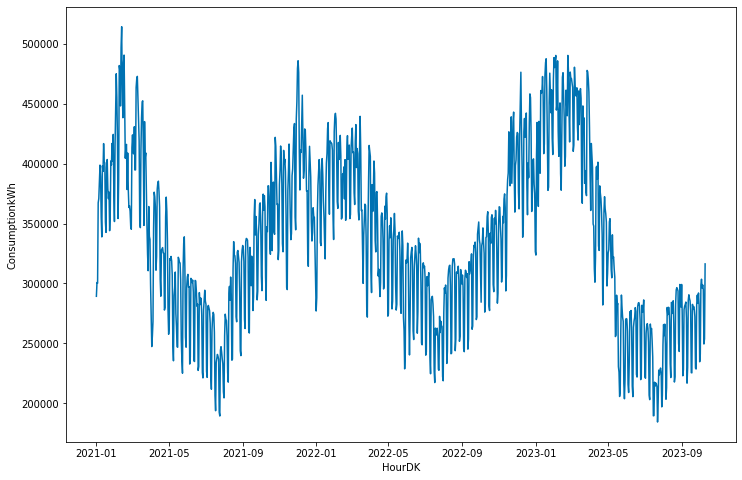

In [20]:
fig = plt.figure(figsize = (12,8))
ax = sns.lineplot(data = df_, x = df_.index, y = df_['ConsumptionkWh'])
plt.show();

mlflow.log_figure(fig, 'Figure.png')

In [ ]:
mlflow.end_run()